In [1]:
# Importing Libraries  
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import plotly.express as px 
import plotly.graph_objects as go  
from plotly.subplots import make_subplots 
from plotly.offline import init_notebook_mode  
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Cleaning Data

In [2]:
# Reading Data  
df = pd.read_csv('/kaggle/input/crop-yield-prediction-dataset/yield_df.csv')
df.head()

Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37

In [3]:
# Drop irrelevant column  
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

Area         Item  Year  hg/ha_yield  average_rain_fall_mm_per_year  \
0  Albania        Maize  1990        36613                         1485.0   
1  Albania     Potatoes  1990        66667                         1485.0   
2  Albania  Rice, paddy  1990        23333                         1485.0   
3  Albania      Sorghum  1990        12500                         1485.0   
4  Albania     Soybeans  1990         7000                         1485.0   

   pesticides_tonnes  avg_temp  
0              121.0     16.37  
1              121.0     16.37  
2              121.0     16.37  
3              121.0     16.37  
4              121.0     16.37

Removing the 'Unnamed: 0' column. 

In [4]:
# Rename misleading column names  
df.rename(columns = {'Area' : 'Country'}, inplace = True)

Renaming the 'Area' column to 'Country' for clarity purposes.

# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB


In [6]:
df['Item'].value_counts() 

Item
Potatoes                4276
Maize                   4121
Wheat                   3857
Rice, paddy             3388
Soybeans                3223
Sorghum                 3039
Sweet potatoes          2890
Cassava                 2045
Yams                     847
Plantains and others     556
Name: count, dtype: int64

In [7]:
df.describe().T

count          mean           std      min  \
Year                           28242.0   2001.544296      7.051905  1990.00   
hg/ha_yield                    28242.0  77053.332094  84956.612897    50.00   
average_rain_fall_mm_per_year  28242.0   1149.055980    709.812150    51.00   
pesticides_tonnes              28242.0  37076.909344  59958.784665     0.04   
avg_temp                       28242.0     20.542627      6.312051     1.30   

                                      25%       50%        75%        max  
Year                            1995.0000   2001.00    2008.00    2013.00  
hg/ha_yield                    19919.2500  38295.00  104676.75  501412.00  
average_rain_fall_mm_per_year    593.0000   1083.00    1668.00    3240.00  
pesticides_tonnes               1702.0000  17529.44   48687.88  367778.00  
avg_temp                          16.7025     21.51      26.00      30.65

In [8]:
df.describe(include = 'object')

Country      Item
count    28242     28242
unique     101        10
top      India  Potatoes
freq      4048      4276

India is the most frequent country in the dataset while potatoes are the most frequent crop.

In [9]:
# Check for the countries with the highest overall crop yield  
df.groupby(['Country'], sort = True)[['hg/ha_yield']].sum().nlargest(10, 'hg/ha_yield')

hg/ha_yield
Country                    
India             327420324
Brazil            167550306
Mexico            130788528
Japan             124470912
Australia         109111062
Pakistan           73897434
Indonesia          69193506
United Kingdom     55419990
Turkey             52263950
Spain              46773540

India by far yields the most crops. The combination of Brazil and Mexico would still not be as much as India's crop yield.

In [10]:
# Check which specific crop yield is the highest respective to their country  
df.groupby(['Item','Country'], sort = True)['hg/ha_yield'].sum().nlargest(10)

Item            Country       
Cassava         India             142810624
Potatoes        India              92122514
                Brazil             49602168
                United Kingdom     46705145
                Australia          45670386
Sweet potatoes  India              44439538
Potatoes        Japan              42918726
                Mexico             42053880
Sweet potatoes  Mexico             35808592
                Australia          35550294
Name: hg/ha_yield, dtype: int64

The highest individual crop yield is Cassava from India. The highest individual crop yields are potatoes or sweet potatoes otherwise.

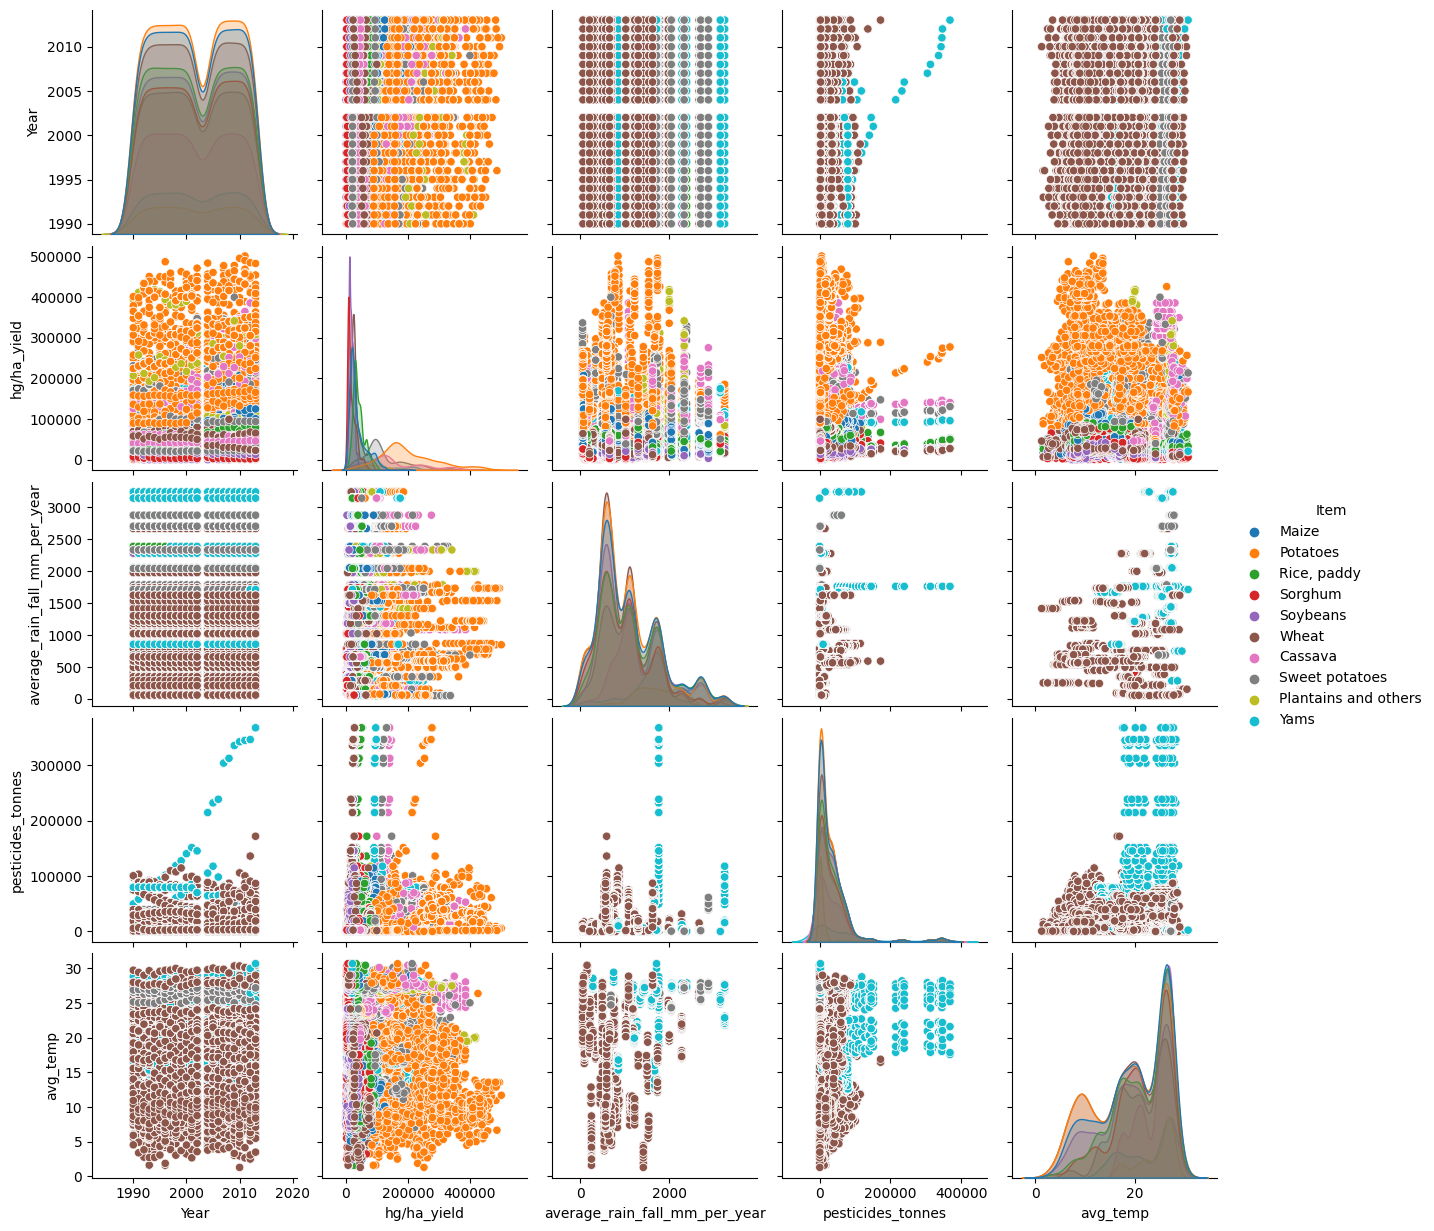

In [11]:
sns.pairplot(data = df, hue = 'Item', kind = 'scatter')

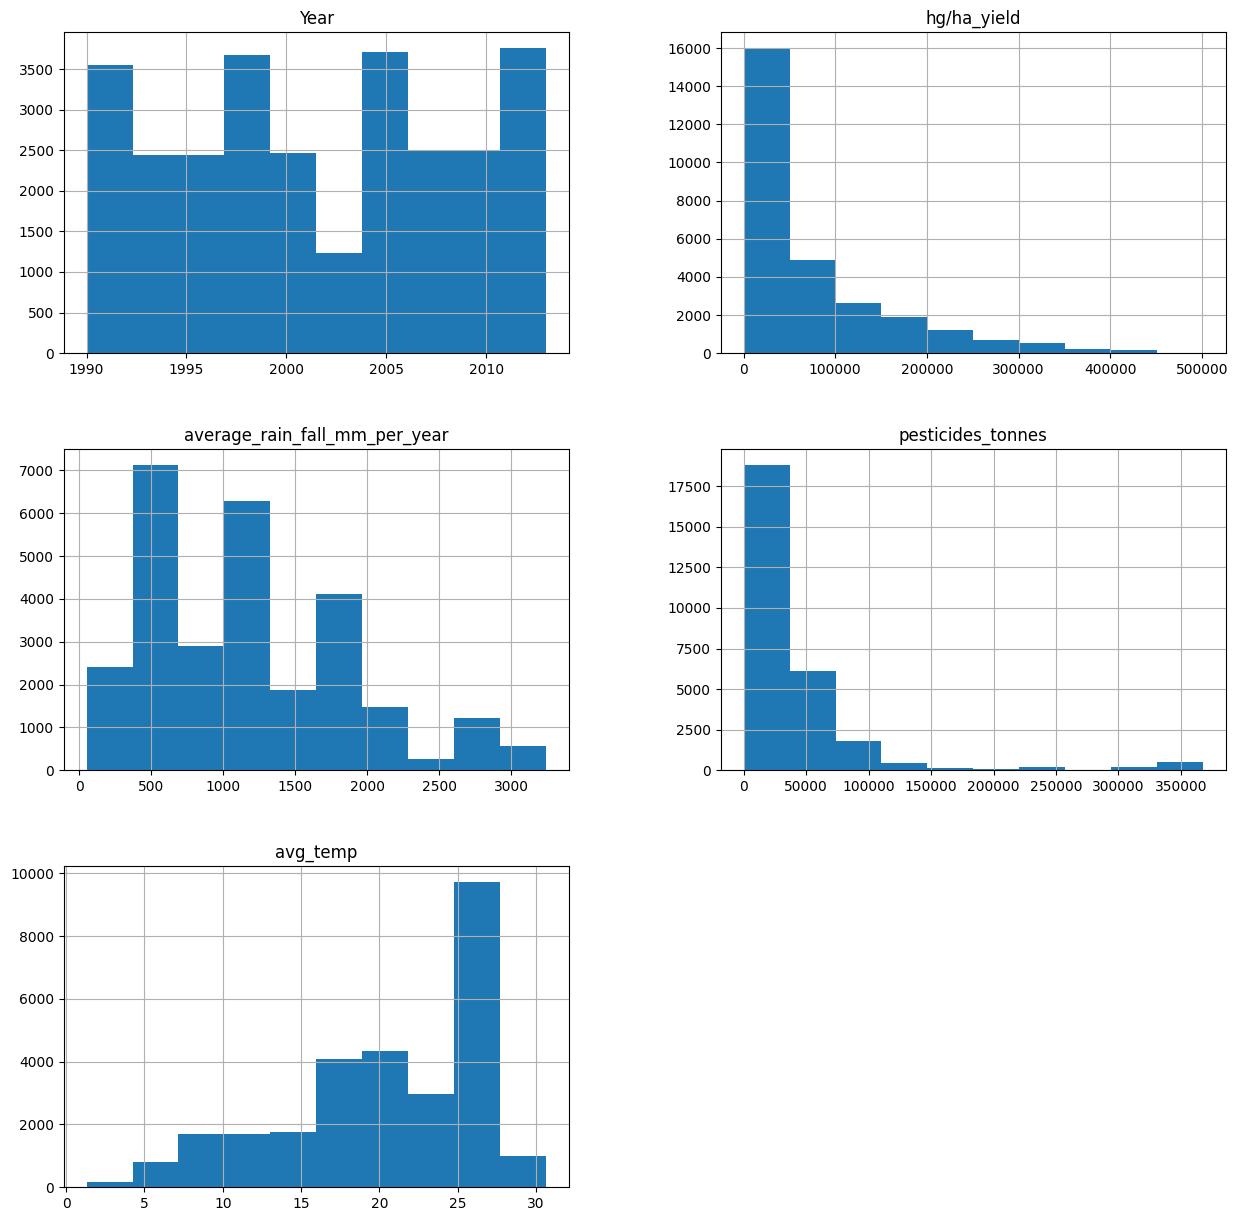

In [12]:
df.hist(figsize = (15, 15));

- Most rainfall is between 0 - 2000 mm.
- Most average temperatures around around 25 degrees celsius.
- Most crop yield is between 0 - 100000 hg / ha.
- Most pesticide use is between 0 - 50000 tons.

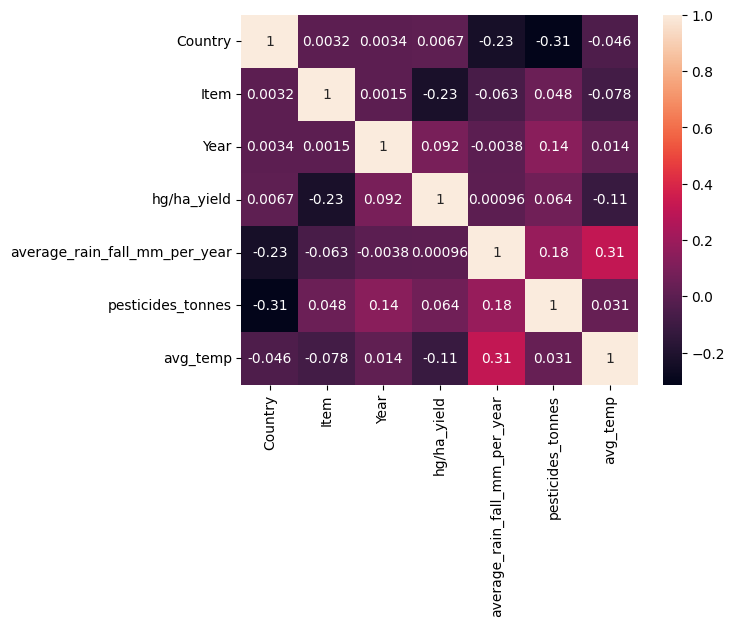

In [13]:
hm = df.copy()

cat_col = hm.select_dtypes(include = ['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in cat_col :
    hm[col] = label_encoder.fit_transform(hm[col])

# Confusion Matrix 
cm = sns.heatmap(hm.corr(), annot = True)
plt.show()

The strongest correlation is between country and pesticides_tonnes. The most likely explanation is that countries can have regulations on pesticides and countries use pesticides based on the prevalence of local pests.

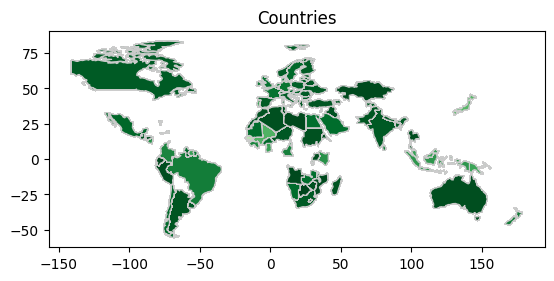

In [14]:
# Map of countries in the dataset  
geojson_url = 'https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson'
data = gpd.read_file(geojson_url)

merged_data = data.merge(df, left_on = 'NAME', right_on = 'Country', how = 'left')

merged_data.plot(column = 'hg/ha_yield', cmap = 'Greens_r', linewidth = 0.8, edgecolor = '0.8')
plt.title('Countries')
plt.show()

Some notable countries not found in the dataset are the US, China, and Russia. These three countries are among the top producing countries of agricultural commodities.

In [15]:
# Delete geojson data  
del merged_data
del data

## Does Pesticide Use Affect Crop Yield?

In [16]:
px.scatter(df, x = 'hg/ha_yield', y = 'pesticides_tonnes', color = 'Country') 

Pesticide use barely affects crop yield. The r value is 0.064 and the plot above displays this extremely weak correlation. For example, Brazil (the orange dots at the top of the plot), has a higher crop yield still being produced with roughly the same amount of pesticides.   

In [17]:
# Method to display 4 interactive plots together vertically 
def four_subplots(plot1, plot2, plot3, plot4, w, h) : 
    figures = [plot1, plot2, plot3, plot4]
    fig = make_subplots(rows = len(figures), cols = 1, vertical_spacing = 0.05)
    
    for i, figure in enumerate(figures) :
        for trace in range(len(figure['data'])) :
            fig.append_trace(figure['data'][trace], row = i + 1, col = 1)
    
    fig.update_layout(width = w, height = h)
            
    return fig  

In [18]:
fig1 = px.scatter(df, x = 'Item', y = 'hg/ha_yield', color = 'Country') 
fig2 = px.scatter(df, x = 'Item', y = 'average_rain_fall_mm_per_year', color = 'Country') 
fig3 = px.scatter(df, x = 'Item', y = 'pesticides_tonnes', color = 'Country') 
fig4 = px.scatter(df, x = 'Item', y = 'avg_temp', color = 'Country' ) 

fig = four_subplots(fig1, fig2, fig3, fig4, 1075, 2500)

# Changing axes labels   
fig.update_xaxes(title_text = 'Item', row = 1, col = 1)
fig.update_xaxes(title_text = 'Item', row = 2, col = 1)
fig.update_xaxes(title_text = 'Item', row = 3, col = 1)
fig.update_xaxes(title_text = 'Item', row = 4, col = 1)

fig.update_yaxes(title_text = 'hg/ha_yield', row = 1, col = 1)
fig.update_yaxes(title_text = 'average_rain_fall_mm_per_year', row = 2, col = 1)
fig.update_yaxes(title_text = 'pesticides_tonnes', row = 3, col = 1)
fig.update_yaxes(title_text = 'avg_temp', row = 4, col = 1)

fig.update_layout(showlegend = False) 


- The top-producing crops are potatoes, cassava, and sweet potatoes.
- Average amount of rainfall is more correlated towards country than crops.
- Brazil uses the most pesticides by far out of any country.
- Cassava, sweet potatoes, yams, and plantains & others grow in warmer climates while the rest of the crops grow in varying climates.

In [19]:
grouped = df.groupby('Item')

top_areas = []

# Create dataframe for the top individual crop yields  
for item, group in grouped :
    max_production_row = group[group['hg/ha_yield'] == group['hg/ha_yield'].max()]
    
    area = max_production_row['Country'].values[0]
    production = max_production_row['hg/ha_yield'].values[0]
    
    top_areas.append({'Item' : item, 'Country' : area, 'hg/ha_yield' : production})

top_areas_df = pd.DataFrame(top_areas)

top_areas_df

Item    Country  hg/ha_yield
0               Cassava      India       385818
1                 Maize      Qatar       207556
2  Plantains and others  Guatemala       418505
3              Potatoes    Belgium       501412
4           Rice, paddy  Australia       103895
5               Sorghum    Algeria       206000
6              Soybeans     Turkey        41609
7        Sweet potatoes    Senegal       400000
8                 Wheat     Zambia        99387
9                  Yams       Mali       250000

In [20]:
px.bar(top_areas_df, x = 'hg/ha_yield', y = 'Country', color = 'Item')  

Each top producer of a specific crop is a different country.

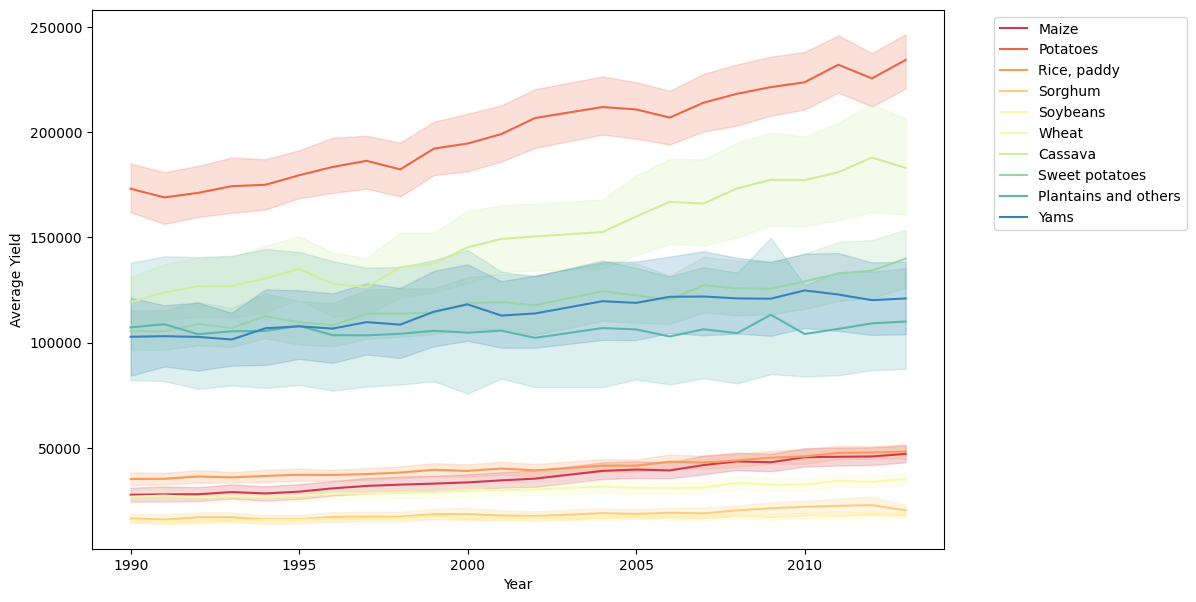

In [32]:
fig1 = px.scatter(df, x = 'pesticides_tonnes', y = 'hg/ha_yield', 
                  labels = {'pesticides_tonnes' : 'Pesticide Tons', 'hg/ha_yield' : 'Average Yield'}, 
                  color = 'Item') 
fig2 = px.scatter(df, x = 'average_rain_fall_mm_per_year', y = 'hg/ha_yield', 
                  labels = {'average_rain_fall_mm_per_year' : 'Average Rainfall (mm) Per Year', 'hg/ha_yield' : 'Average Yield'}, 
                  color = 'Item') 
fig3 = px.scatter(df, x = 'avg_temp', y = 'hg/ha_yield', 
                  labels = {'avg_temp' : 'Average Temperature', 'hg/ha_yield' : 'Average Yield'}, 
                  color = 'Item') 
fig4 = sns.lineplot(x = 'Year', y = 'hg/ha_yield', hue = 'Item', data = df, legend = True, palette = 'Spectral')

fig1.show()
fig2.show()
fig3.show()

fig4.set(ylabel = 'Average Yield')
fig4.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.gcf().set_size_inches(11, 7) 
plt.show()

- Crop yield slightly decreases as pesticide usage increases.
- Crop yield slightly decreases as average rainfall increases after 2000 mm.
- Crop yield slightly decreases as the average temperature decreases before 5 Celsius.
- Crop yield has gradually increased over time.

In [22]:
fig1 = px.line(df.groupby(['Year'])['hg/ha_yield'].mean(), 
               labels = {'value' : 'hg/ha_yield'}) 
fig2 = px.line(df.groupby(['Year'])['average_rain_fall_mm_per_year'].mean(), 
               labels = {'value' : 'average_rain_fall_mm_per_year'}) 
fig3 = px.line(df.groupby(['Year'])['pesticides_tonnes'].mean(), 
               labels = {'value' : 'pesticides_tonnes'}) 
fig4 = px.line(df.groupby(['Year'])['avg_temp'].mean(), 
               labels = {'value' : 'avg_temp'}) 

fig1.show()
fig2.show()
fig3.show()
fig4.show()


- Crop yield has gradually increased over time.
- Average rainfall dropped significantly between 1990 - 1993 and has remained stable since then.
- Pesticide use has gradually increased over time.
- The average temperature has slightly increased over time.

# Preprocessing Data

In [23]:
x, y = df.drop(labels = 'hg/ha_yield', axis = 1), df['hg/ha_yield']
# Convert data into dummy variables 
x = pd.get_dummies(x)

In [24]:
# Split the data into train and test sets 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

# Machine Learning Models

In [25]:
results = []

# List of machine learning models that will be trained  
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state = 1)),
    ('Random Forest', RandomForestRegressor(random_state = 1)),
    ('Gradient Boost', GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 1)),
    ('XGBoost', XGBRegressor(random_state = 1)),
    ('Bagging Regressor', BaggingRegressor(n_estimators = 100, random_state = 1)),  
    ('KNN', KNeighborsRegressor(n_neighbors = 10))]

In [33]:
# Loops through the list of machine learning models above  
for name, model in models :
    # Train Model  
    model.fit(x_train, y_train)  
    # Make Predictions   
    y_pred = model.predict(x_test)                      
    
    accuracy = model.score(x_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    # Add all metrics of model to a list    
    results.append((name, accuracy, MSE, R2_score))     
    
    acc = (model.score(x_train , y_train) * 100)
    print(f'Accuracy of {name} Model Train is {acc:.2f}')
    acc = (model.score(x_test , y_test) * 100)
    print(f'Accuracy of the {name} Model Test is {acc:.2f}')  
    
    data = {'y_test' : [y_test], 
            'y_pred' : [y_pred]} 
    data_df = pd.DataFrame(data)
    
    fig = px.scatter(data_df, x = y_test, y = y_pred, 
                     labels = {'x' : 'Actual Values', 'y' : 'Predicted Values'},  
                     trendline = 'ols', trendline_color_override = 'red')
    fig.show()

Accuracy of Linear Regression Model Train is 75.73
Accuracy of the Linear Regression Model Test is 75.14


Accuracy of Decision Tree Model Train is 100.00
Accuracy of the Decision Tree Model Test is 97.82


Accuracy of Random Forest Model Train is 99.84
Accuracy of the Random Forest Model Test is 98.48


Accuracy of Gradient Boost Model Train is 87.53
Accuracy of the Gradient Boost Model Test is 86.51


Accuracy of XGBoost Model Train is 98.37
Accuracy of the XGBoost Model Test is 97.35


Accuracy of Bagging Regressor Model Train is 99.84
Accuracy of the Bagging Regressor Model Test is 98.48


Accuracy of KNN Model Train is 46.17
Accuracy of the KNN Model Test is 33.27


## Comparing Models

In [35]:
# Dataframe consisting of metrics of all the models   
results_df = pd.DataFrame(results, columns = ['Model', 'Accuracy', 'MSE', 'R2_score'])
# Add red and green highlights in the dataframe to display best and worst performing models  
results_format_df = results_df.style.highlight_max(subset = ['Accuracy', 'R2_score'], color = 'green').highlight_min(subset = ['MSE'], color = 'green').highlight_max(subset = ['MSE'], color = 'red').highlight_min(subset = ['Accuracy','R2_score'], color = 'red')
display(results_format_df)

The Random Forest model was the most accurate with the Bagging Regressor, Decision Tree, and XGBoost models extremely close behind. Out of the 7 models tested, these four models are by far the best models to utilize for predicting crop yield. The KNN model was by far the worst. The Linear Regression and Gradient Boost models had somewhat high accuracy, but not nearly as high as the aforementioned four models.

# K-Fold Cross Validation

In [36]:
results = [] 
fold_df = pd.DataFrame()

# Loops through the list of machine learning models   
for name, model in models :
    # Train Model   
    model.fit(x_train, y_train)
    # Make Predictions     
    y_pred = model.predict(x_test)
    accuracy = model.score(x_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    # Add all metrics of model to a list      
    results.append((name, accuracy, MSE, MAE, MAPE, R2_score))
    
    print(name)
    kf = KFold(n_splits = 10, shuffle = True)
    scores = cross_val_score(model, x, y, cv = kf)
    
    # Print out the CV Scores for each fold  
    for fold, score in enumerate(scores) :
        print(f'Fold {fold + 1}: {score}')
        temp_df = pd.DataFrame({'Name' : name, 'Fold' : [fold + 1], 'Score' : [score]}) 
        dfs = [fold_df, temp_df] 
        fold_df = pd.concat(dfs, ignore_index = True)

    # Print out the Mean CV scores for each model     
    mean_score = np.mean(scores)
    print(f'Mean Score: {mean_score}')
    print('=' * 30)

Linear Regression
Fold 1: 0.7592588059967479
Fold 2: 0.7355517895454585
Fold 3: 0.7314434110766754
Fold 4: 0.7657322721286852
Fold 5: 0.7738489069636582
Fold 6: 0.7546154728949589
Fold 7: 0.7526170661417704
Fold 8: 0.7521159087794901
Fold 9: 0.7529353613302543
Fold 10: 0.7563090734030162
Mean Score: 0.7534428068260715
Decision Tree
Fold 1: 0.9782959761631065
Fold 2: 0.980643629565529
Fold 3: 0.9790785768673617
Fold 4: 0.9814595951729757
Fold 5: 0.9832027449289803
Fold 6: 0.985653641607325
Fold 7: 0.9847644135420301
Fold 8: 0.9818282361834682
Fold 9: 0.9845346658749655
Fold 10: 0.9864504045163751
Mean Score: 0.9825911884422117
Random Forest
Fold 1: 0.9894516605395332
Fold 2: 0.9897614845531935
Fold 3: 0.9877780974689184
Fold 4: 0.9888682528021078
Fold 5: 0.990763789394106
Fold 6: 0.9866196460835867
Fold 7: 0.9896219661271093
Fold 8: 0.9910586794131209
Fold 9: 0.9883325543456131
Fold 10: 0.9906343939541059
Mean Score: 0.9892890524681395
Gradient Boost
Fold 1: 0.8762063228637476
Fold 2: 0

In [37]:
for i in range(1, 8) : 
    plot_fold_df = fold_df.iloc[i * 10 - 10 : i * 10] 
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = plot_fold_df['Fold'],
                             y = plot_fold_df['Score'],
                             mode = 'lines+markers',
                             name = 'Accuracy'))

    fig.update_layout(title = {'text' : plot_fold_df['Name'].iloc[i],
                       'xanchor' : 'center',
                       'yanchor' : 'top',
                       'x' : 0.5},
                       xaxis_title = 'Fold',
                       yaxis_title = 'Score',
                       title_font = dict(size = 20))
    
    fig.show()

All of the models except for the Linear Regression and Random Forest models have the highest CV score within the 1 - 5 folds.

## Comparing Models

In [38]:
# Dataframe consisting of metrics of all the models     
result_df = pd.DataFrame(results, columns = ['Model', 'Accuracy', 'MSE', 'MAE', 'MAPE', 'R2_score'])
# Add red and green highlights in the dataframe to display best and worst performing models  
result_format_df = result_df.style.highlight_max(subset = ['Accuracy','R2_score'], color = 'green').highlight_min(subset = ['MSE','MAE','MAPE'], color = 'green').highlight_max(subset = ['MSE','MAE','MAPE'], color = 'red').highlight_min(subset = ['Accuracy','R2_score'], color = 'red')
display(result_format_df)

Utilizing K-Fold cross-validation, the Random Forest model still remains the best model. The KNN still remains the worst model. There is no significant change in any of the models' accuracy when using K-Fold cross-validation.

## Save Models

In [39]:
from joblib import dump  # For scikit-learn versions older than 0.23
# For scikit-learn versions 0.23 and newer, use: from joblib import dump

results = [] 
fold_df = pd.DataFrame()

# Loops through the list of machine learning models   
for name, model in models:
    # Save the trained model to disk
    model_filename = f"{name}_model.joblib"
    dump(model, model_filename)